In [6]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, stack, zeros, vstack
from src.plots import plot_vae_training_result, plot_image, plot_image_label_two
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier
from src.utils import frechet_inception_distance

device = device('cuda' if cuda.is_available() else 'cpu')

In [7]:
training_data = torchvision.datasets.FashionMNIST(root='../../data/FMNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.FashionMNIST(root='../../data/FMNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(training_data)
print(testing_data)

input = training_data.data[:60000] / 255.0    # normalizing necessary to make pixels in [0, 1] range for FID
labels = training_data.targets[:60000]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../../data/FMNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../../data/FMNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10


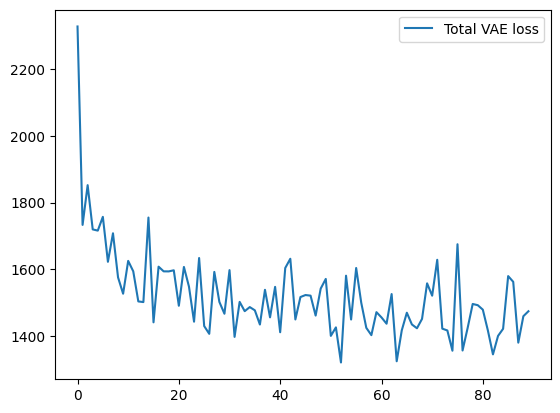

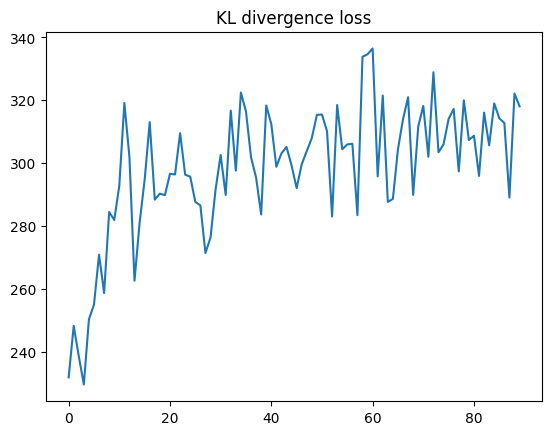

In [8]:
# parameters
model = "cvae"
dataset = "fmnist"
batch_size = 64
epoch = 10
learning_rate = 0.001

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

# TODO: save plotting results
if os.path.exists(model_path):
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=3).to(device)

    # try with model sigma
    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

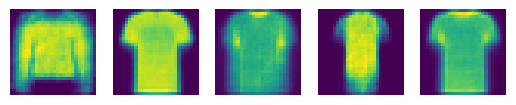

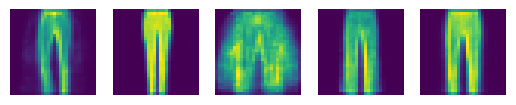

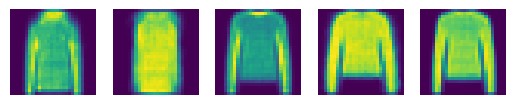

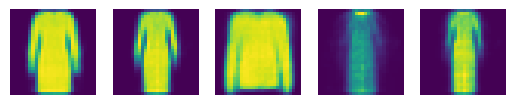

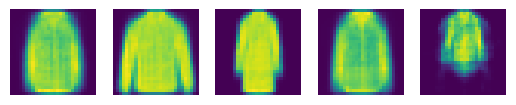

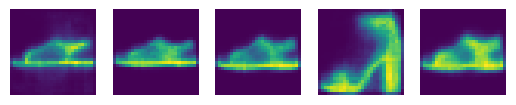

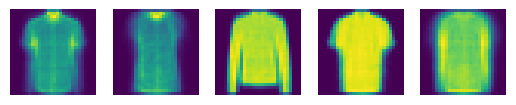

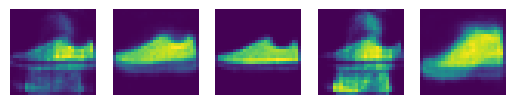

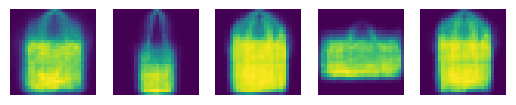

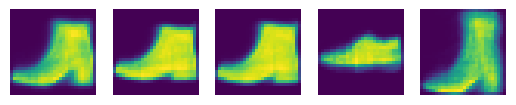

In [9]:
for i in range(10):
    images = vae.generate_data(n_samples=5, target_label=i)
    plot_image(images)

In [10]:
# train classifier for performance evaluation
model = "classifier"
dataset = "fmnist"
batch_size = 64
epoch = 10

classifier_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}.pt"

if os.path.exists(classifier_path):
    classifier = load(classifier_path)
else:
    classifier = MNISTClassifier(input_size=784, num_classes=10)
    classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)
save(classifier, classifier_path)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Epoch done:  6
Epoch done:  7
Epoch done:  8
Epoch done:  9
Epoch done:  10
Test accuracy:  0.8811


In [41]:
# generate data for testing on classifier
# this one stays the same
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

Wrong count:  2157
Accuracy:  0.7843


In [42]:
# Determine FID
# generate 500 images
# normalizing necessary to make pixels in [0, 1] range for FID

testing_data = torchvision.datasets.MNIST(root='../../data/FMNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

num_data = 100

input = testing_data.data[:num_data] / 255.0
syn_input = vae.generate_data(n_samples=num_data)

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)

Frechet Inception Distance:  tensor(276.3321)


In [43]:
# test global model

# model_path = f"../../models/cvae_30_cvae_0.9_cvae.pth"
vae = load(model_path)

data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

ModuleNotFoundError: No module named 'vae'